# Resilient Distributed Dataset (RDD)

RDD - fundamental building block/data structure of PySpark. RDDs are immutable, fault-tolerant collection of objects. 

RDD can be compared with the Python lists. Unlike Python lists, RDDs are being computed on several processes distributed across multiple physical servers (nodes) in a cluster. RDDs are the main logical data units in Spark.

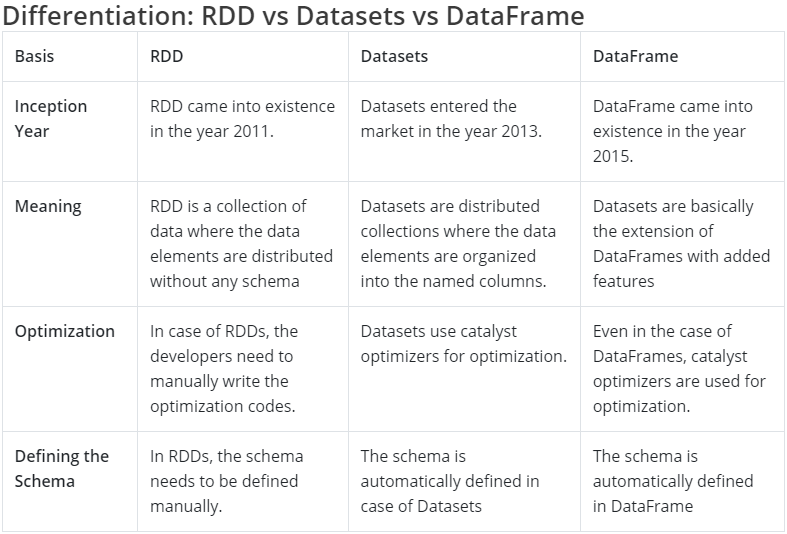


There are only TWO operations that can be done on the RDDs - TRANSFORMATIONS and ACTIONS. 

---------------

Transformations - one RDD as an input --> one new RDD as an output by applying some function or operation on an initial RDD.

Actions - operations that trigger the computation on the RDD and return the results.

More about transformations and actions [here](https://data-flair.training/blogs/spark-rdd-operations-transformations-actions/)

---------------

The main applications of RDDs are data processing, ML, streaming, graph processing

RDDs can be created in two different ways:

- Using parallelization of an existing collection

- Referencing a dataset in an external storage system

In [58]:
# Import modules

from pyspark.sql import SparkSession # SQL reference
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, TimestampType
from pyspark.sql.functions import col
import multiprocessing
import sys
import os
import csv

# Check python version (To fix troubles in different versions in worker & driver nodes)
print(sys.version)

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]


In [59]:
# Create spark session

spark = SparkSession.builder.appName('RDDTest').getOrCreate()

print(spark)

### RDD Creation

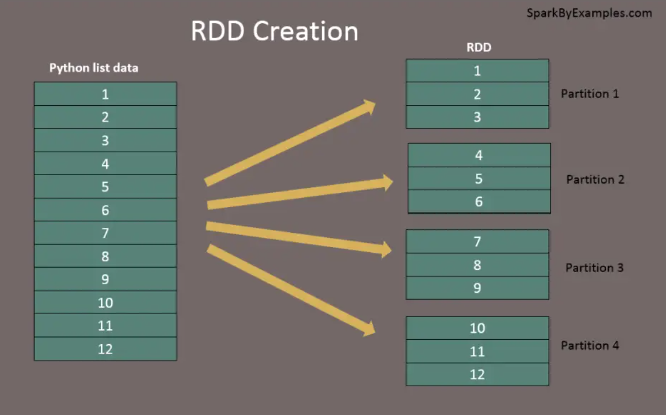

**By running RDDs on the local machine (laptop) the data will be split in partitions based on the amount of logical processors (Ctrl + Shift + Esc)**

In [60]:
# Simple list parallelization 

# data = [1, 2, 4, 5, 1, 6, 12, 67, 76, 17, 43]

data = [("Alice", "Female", 25, 50000, "New York"),
        ("Bob", "Male", 30, 60000, "Chicago"),
        ("Charlie", "Male", 35, 70000, "San Francisco"),
        ("Diana", "Female", 40, 80000, "Los Angeles")]

rdd = spark.sparkContext.parallelize(data)

print('Number of logical processors (CPUs):', multiprocessing.cpu_count())
print('Number of RDD partitions: ', rdd.getNumPartitions())
print("ID:", rdd.id())
print("Name:", rdd.name())
print("Context:", rdd.context)
print("Cached?:", rdd.is_cached)
print("Checkpointed?:", rdd.is_checkpointed)
print(rdd.collect())

Number of logical processors (CPUs): 16
Number of RDD partitions:  16
ID: 229
Name: None
Context: <SparkContext master=local[*] appName=RDDTest>
Cached?: False
Checkpointed?: False
[('Alice', 'Female', 25, 50000, 'New York'), ('Bob', 'Male', 30, 60000, 'Chicago'), ('Charlie', 'Male', 35, 70000, 'San Francisco'), ('Diana', 'Female', 40, 80000, 'Los Angeles')]


In [61]:
# List parallelization with text

text_data = 'testing_doc.txt'

rdd_text = spark.sparkContext.textFile(text_data)
print(rdd_text)

testing_doc.txt MapPartitionsRDD[231] at textFile at <unknown>:0


In [62]:
# Manual list parallelization

rdd_manual = spark.sparkContext.parallelize(data, 10) # use 10 processors only

print('Number of RDD partitions: ', rdd_manual.getNumPartitions())

Number of RDD partitions:  10


### DataFrames in Spark



In [63]:
# Create DF from RDD

df = rdd.toDF(["Name", "Gender", "Age", "Salary", "Location"])

df.show()

+-------+------+---+------+-------------+
|   Name|Gender|Age|Salary|     Location|
+-------+------+---+------+-------------+
|  Alice|Female| 25| 50000|     New York|
|    Bob|  Male| 30| 60000|      Chicago|
|Charlie|  Male| 35| 70000|San Francisco|
|  Diana|Female| 40| 80000|  Los Angeles|
+-------+------+---+------+-------------+



In [64]:
# CSV --> RDD --> DF | TRAIN DATA

rdd_train = spark.sparkContext.textFile("raw_data/poker-hand-training-true.csv")

columns = ["Column1", "Column2",	
           "Column3", "Column4",	
           "Column5", "Column6",	
           "Column7", "Column8",	
           "Column9", "Column10",	
           "Column11"]

# ToDo: Understand how schema works
schema = StructType([
    StructField("Column1", IntegerType(), True),
    StructField("Column2", IntegerType(), True),
    StructField("Column3", IntegerType(), True),
    StructField("Column4", IntegerType(), True),
    StructField("Column5", IntegerType(), True),
    StructField("Column6", IntegerType(), True),
    StructField("Column7", IntegerType(), True),
    StructField("Column8", IntegerType(), True),
    StructField("Column9", IntegerType(), True),
    StructField("Column10", IntegerType(), True),
    StructField("Column11", IntegerType(), True)
])

parsed_rdd_train = rdd_train.map(lambda line: list(csv.reader([line]))[0])

df_train = parsed_rdd_train.toDF(columns)

num_rows = df_train.count()
num_cols = len(df_train.columns)

print("Shape of the DataFrame: ({}, {})".format(num_rows, num_cols))

df_train.show(5)

Shape of the DataFrame: (25010, 11)
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
|Column1|Column2|Column3|Column4|Column5|Column6|Column7|Column8|Column9|Column10|Column11|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
|      1|     10|      1|     11|      1|     13|      1|     12|      1|       1|       9|
|      2|     11|      2|     13|      2|     10|      2|     12|      2|       1|       9|
|      3|     12|      3|     11|      3|     13|      3|     10|      3|       1|       9|
|      4|     10|      4|     11|      4|      1|      4|     13|      4|      12|       9|
|      4|      1|      4|     13|      4|     12|      4|     11|      4|      10|       9|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
only showing top 5 rows



In [65]:
# CSV --> RDD --> DF | TEST DATA

rdd_test = spark.sparkContext.textFile("raw_data/poker-hand-testing.csv")

columns = ["Column1",	"Column2",	
           "Column3",	"Column4",	
           "Column5",	"Column6",	
           "Column7",	"Column8",	
           "Column9",	"Column10",	
           "Column11"]

parsed_rdd_test = rdd_test.map(lambda line: list(csv.reader([line]))[0])

df_test = parsed_rdd_test.toDF(columns)

num_rows = df_test.count()
num_cols = len(df_test.columns)

print("Shape of the DataFrame: ({}, {})".format(num_rows, num_cols))

df_test.show(5)

Shape of the DataFrame: (1000000, 11)
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
|Column1|Column2|Column3|Column4|Column5|Column6|Column7|Column8|Column9|Column10|Column11|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
|      1|      1|      1|     13|      2|      4|      2|      3|      1|      12|       0|
|      3|     12|      3|      2|      3|     11|      4|      5|      2|       5|       1|
|      1|      9|      4|      6|      1|      4|      3|      2|      3|       9|       1|
|      1|      4|      3|     13|      2|     13|      2|      1|      3|       6|       1|
|      3|     10|      2|      7|      1|      2|      2|     11|      4|       9|       0|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+
only showing top 5 rows



In [66]:
# Print the schema of the DF

df_train.printSchema()

root
 |-- Column1: string (nullable = true)
 |-- Column2: string (nullable = true)
 |-- Column3: string (nullable = true)
 |-- Column4: string (nullable = true)
 |-- Column5: string (nullable = true)
 |-- Column6: string (nullable = true)
 |-- Column7: string (nullable = true)
 |-- Column8: string (nullable = true)
 |-- Column9: string (nullable = true)
 |-- Column10: string (nullable = true)
 |-- Column11: string (nullable = true)



### RDD Operations - Transformations & Actions

**Transformations** - one RDD as an input --> one new RDD as an output by applying some function or operation on an initial RDD.

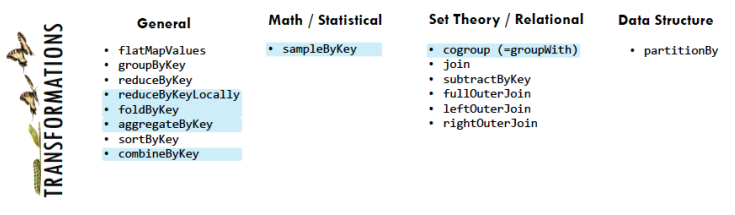

**Actions** - operations that trigger the computation on the RDD and return the results.

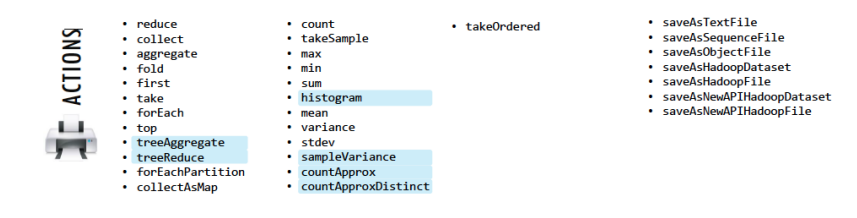
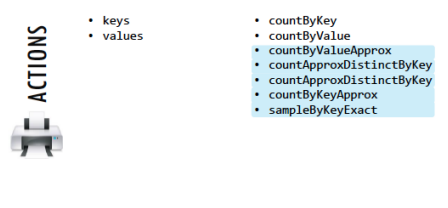

In [67]:
# Change the schema of the DF

schema = StructType([
    StructField("Permit Number", StringType(), True),
    StructField("Permit Type", StringType(), True),
    StructField("Permit Type Definition", StringType(), True),
    StructField("Permit Creation Date", TimestampType(), True),
    StructField("Block", StringType(), True),
    StructField("Lot", StringType(), True),
    StructField("Street Number", IntegerType(), True),
    StructField("Street Number Suffix", StringType(), True),
    StructField("Street Name", StringType(), True),
    StructField("Street Suffix", StringType(), True),
    StructField("Unit", StringType(), True),
    StructField("Unit Suffix", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Current Status", StringType(), True),
    StructField("Current Status Date", TimestampType(), True),
    StructField("Filed Date", TimestampType(), True),
    StructField("Issued Date", TimestampType(), True),
    StructField("Completed Date", TimestampType(), True),
    StructField("First Construction Document Date", TimestampType(), True),
    StructField("Structural Notification", StringType(), True),
    StructField("Number of Existing Stories", IntegerType(), True),
    StructField("Number of Proposed Stories", IntegerType(), True),
    StructField("Voluntary Soft-Story Retrofit", StringType(), True),
    StructField("Fire Only Permit", StringType(), True),
    StructField("Permit Expiration Date", DateType(), True),
    StructField("Estimated Cost", IntegerType(), True),
    StructField("Revised Cost", IntegerType(), True),
    StructField("Existing Use", StringType(), True),
    StructField("Existing Units", IntegerType(), True),
    StructField("Proposed Use", StringType(), True),
    StructField("Proposed Units", IntegerType(), True),
    StructField("Plansets", IntegerType(), True),
    StructField("TIDF Compliance", StringType(), True),
    StructField("Existing Construction Type", StringType(), True),
    StructField("Existing Construction Type Description", StringType(), True),
    StructField("Proposed Construction Type", StringType(), True),
    StructField("Proposed Construction Type Description", StringType(), True),
    StructField("Site Permit", StringType(), True),
    StructField("Supervisor District", IntegerType(), True),
    StructField("Neighborhoods - Analysis Boundaries", StringType(), True),
    StructField("Zipcode", IntegerType(), True),
    StructField("Location", StringType(), True),
    StructField("Record ID", IntegerType(), True)
])

In [68]:
# Import data
# P.S. for this section a "dirty" dataset will be used

dirty_df = spark.read.format("csv").option("header", "true").schema(schema).load("raw_data/building_permits.csv")

print('Datatypes: ', dirty_df.dtypes)

dirty_df.show(5)

Datatypes:  [('Permit Number', 'string'), ('Permit Type', 'string'), ('Permit Type Definition', 'string'), ('Permit Creation Date', 'timestamp'), ('Block', 'string'), ('Lot', 'string'), ('Street Number', 'int'), ('Street Number Suffix', 'string'), ('Street Name', 'string'), ('Street Suffix', 'string'), ('Unit', 'string'), ('Unit Suffix', 'string'), ('Description', 'string'), ('Current Status', 'string'), ('Current Status Date', 'timestamp'), ('Filed Date', 'timestamp'), ('Issued Date', 'timestamp'), ('Completed Date', 'timestamp'), ('First Construction Document Date', 'timestamp'), ('Structural Notification', 'string'), ('Number of Existing Stories', 'int'), ('Number of Proposed Stories', 'int'), ('Voluntary Soft-Story Retrofit', 'string'), ('Fire Only Permit', 'string'), ('Permit Expiration Date', 'date'), ('Estimated Cost', 'int'), ('Revised Cost', 'int'), ('Existing Use', 'string'), ('Existing Units', 'int'), ('Proposed Use', 'string'), ('Proposed Units', 'int'), ('Plansets', 'int')

In [75]:
# Changed schema for the imported CSV

dirty_df.printSchema()

root
 |-- Permit Number: string (nullable = true)
 |-- Permit Type: string (nullable = true)
 |-- Permit Type Definition: string (nullable = true)
 |-- Permit Creation Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- Lot: string (nullable = true)
 |-- Street Number: integer (nullable = true)
 |-- Street Number Suffix: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Street Suffix: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Unit Suffix: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Current Status: string (nullable = true)
 |-- Current Status Date: timestamp (nullable = true)
 |-- Filed Date: timestamp (nullable = true)
 |-- Issued Date: timestamp (nullable = true)
 |-- Completed Date: timestamp (nullable = true)
 |-- First Construction Document Date: timestamp (nullable = true)
 |-- Structural Notification: string (nullable = true)
 |-- Number of Existing Stories: integer (nullable = tru

In [76]:
# Fill zero values

dirty_df.fillna('MISSING VALUE').show(5)

+-------------+-----------+----------------------+--------------------+-----+---+-------------+--------------------+-----------+-------------+-------------+-------------+--------------------+--------------+-------------------+----------+-----------+--------------+--------------------------------+-----------------------+--------------------------+--------------------------+-----------------------------+----------------+----------------------+--------------+------------+-------------------+--------------+-----------------+--------------+--------+---------------+--------------------------+--------------------------------------+--------------------------+--------------------------------------+-------------+-------------------+-----------------------------------+-------+--------------------+---------+
|Permit Number|Permit Type|Permit Type Definition|Permit Creation Date|Block|Lot|Street Number|Street Number Suffix|Street Name|Street Suffix|         Unit|  Unit Suffix|         Description|C

In [88]:
# Print unique values of a column

unique_values = dirty_df.select('Street Suffix').distinct().rdd.flatMap(lambda x: x).collect()

# Print the unique values
for val in unique_values:
    print(val)

Cr
Wy
Rd
None
Al
Hy
Pk
St
Ct
Dr
Ln
Tr
Bl
Pl
Av
Pz
Wk
Rw
So
Sw
No
Hl


### Repartition & Coalesce

Both are methods for changing the number of paritions in the dataset.

**Repartition** - shuffling data from all nodes/all the network (full shuffle). 


**Coalesce** - shuffling data from minimum nodes --> minimization of partitions in the dataset. If possible, it will avoid a full shuffle of the data. 

Usually, coalesce is faster than repartition.

Both are very expensive operations as they shuffle the data across many partitions --> MINIMIZE USAGE

In [72]:
# Repartition & Coalesce

# To be continued...